# CH4 Time Series Modeling
**Objective**: Develop a SARIMA model for forecasting atmospheric methane concentration

## Input Data
'data/processed/all_ghg_aligned_nan.csv'

## Stages
1. train/test split
2. test data transformations (log and differencing)
3. Auto-ARIMA parameter search
4. SARIMA model selection

In [1]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

# Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import boxcox 
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white, het_arch

from src.preprocessing import GasPreprocessor
from src.forecast_metrics import forecast_metrics
print('GasPreprocessor imported successfully!')
print('forecast_metrics imported successfully!')

GasPreprocessor imported successfully!
forecast_metrics imported successfully!


# Load the Data

In [3]:
df_combined = pd.read_csv('../data/processed/all_ghg_aligned_nan.csv',
                          parse_dates=['date'], index_col='date')

# Split the Data Into Training, Validation, and Testing Sets

In [14]:
# I will split the data into train, validation, and test sets to ensure no data-leakage during model hyperparameter tuning 
# test set will be the final 52 data points (1 year of data)
# validation set will be the 52 data points immediately preceeding the test set

CH4_train, CH4_valid, CH4_test = df_combined[['CH4']].iloc[:-104], df_combined[['CH4']].iloc[-104:-52], df_combined[['CH4']].iloc[-52:]

print(f'Train data: {CH4_train.shape[0]} data points, from {CH4_train.index.min()} to {CH4_train.index.max()}')
print(f'Validation data: {CH4_valid.shape[0]} data points, from {CH4_valid.index.min()} to {CH4_valid.index.max()}')
print(f'Test data: {CH4_test.shape[0]} data points, from {CH4_test.index.min()} to {CH4_test.index.max()}')

Train data: 2458 data points, from 1969-08-20 00:00:00 to 2022-10-20 00:00:00
Validation data: 52 data points, from 2022-10-25 00:00:00 to 2023-12-19 00:00:00
Test data: 52 data points, from 2023-12-26 00:00:00 to 2025-04-03 00:00:00


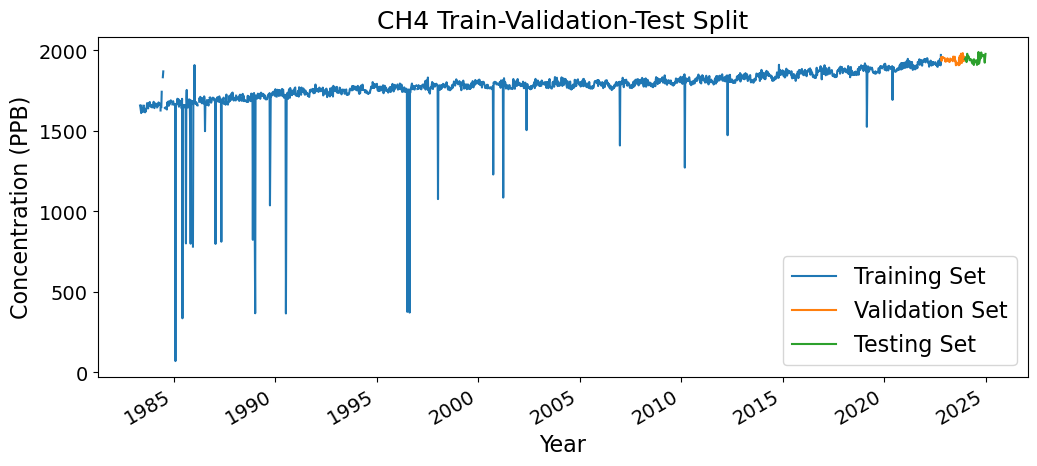

In [5]:
# visually confirm the data split

fig, ax = plt.subplots(figsize=(12,5))
CH4_train['CH4'].plot(ax=ax, label='Training Set')
CH4_valid['CH4'].plot(ax=ax, label='Validation Set')
CH4_test['CH4'].plot(ax=ax, label='Testing Set')

ax.legend(fontsize=16)
ax.set_title('CH4 Train-Validation-Test Split', fontsize=18)
ax.set_ylabel('Concentration (PPB)', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

# Preprocessing and EDA of CH4 Train Set

In [15]:
# reset index to make 'date' column
CH4_train_with_date = CH4_train.reset_index()
CH4_valid_with_date = CH4_valid.reset_index()
CH4_test_with_date = CH4_test.reset_index()

print(f'Train data after resetting index: {CH4_train_with_date.shape[0]} data points')
print(f'Validation data after resetting index: {CH4_valid_with_date.shape[0]} data points')
print(f'Test data after resetting index: {CH4_test_with_date.shape[0]} data points')

Train data after resetting index: 2458 data points
Validation data after resetting index: 52 data points
Test data after resetting index: 52 data points



[INFO] Fitting preprocessing for CH4
Data collection start date for CH4: 1983-05-06 00:00:00
Raw data: 2458 points, 432 NaNs
Trimmed data: 2070 points, 44 NaNs
After resampling: 2060 points, 58 NaNs
[INFO] Found 142 potential outliers using robust STL residuals.
After outlier removal: 2060 points, 200 NaNs
After smoothing: 2060 points, 1 NaNs
After interpolation: 2060 points, 0 NaNs


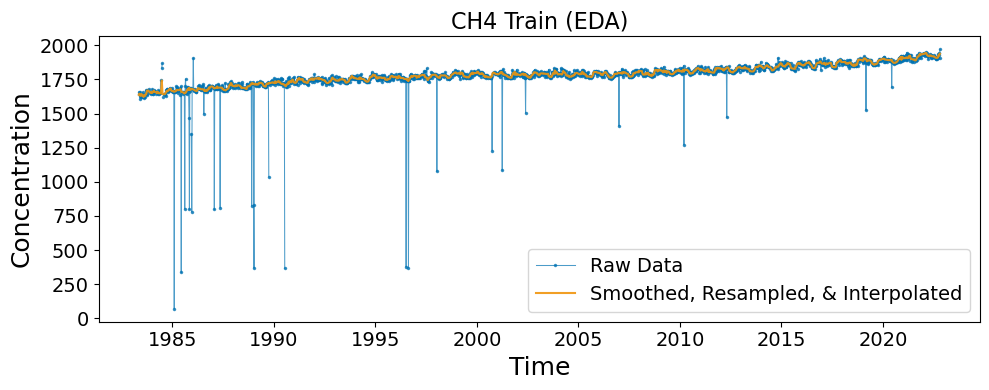

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -1.1315
ADF p-value 0.7023
ADF critical values: {'1%': -3.4335595821169127, '5%': -2.8629578358389685, '10%': -2.5675247926278355}

KPSS statistic 6.5411
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:379: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


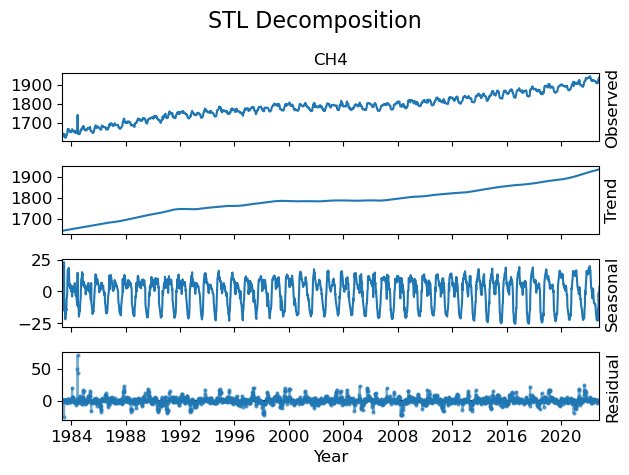

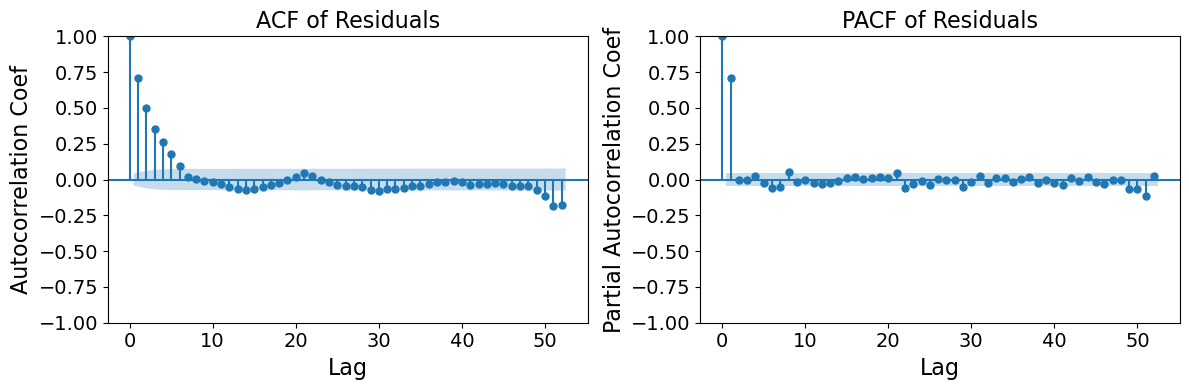


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0048
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0018
Heteroscedasticity detected (White test)


In [7]:
# fit and transform the training data to the GasPreprocessor class
# transform the validation and test data using the fitted preprocessor

CH4_train_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True)
CH4_train_preprocessed = CH4_train_preprocessor.fit_transform(
    CH4_train_with_date, 
    custom_title = 'CH4 Train (EDA)'
)

# transform the validation and test data using the fitted preprocessor
CH4_valid_preprocessed = CH4_train_preprocessor.transform(CH4_valid_with_date)
CH4_test_preprocessed = CH4_train_preprocessor.transform(CH4_test_with_date)

The ACF plot has significant spikes at lags 1-5 (not including the first lag (lag 0)) and mildly oscillating behavior.  This suggests that autocorrelation exists in the training set after preprocessing.  Also notable are the significance of lags around 52 indicating seasonal autocorrelation.  

The gradual tapering down of significan lags in the ACF plot and the sharp cut off after lag 1 in the PACF plot suggest an AR(p) model, possibly AR(1).  

Initial analysis of the STL decomposition indicated a stable seasonal pattern and seemingly well-behaved residuals, suggesting the preprocessed data was ready for modeling. However, a more rigorous validation on the training set alone revealed a crucial nuance: statistical tests (Breusch-Pagan, White) confirmed the presence of heteroscedasticity in the residuals (p < 0.05). This means the variance of the unexplained noise is not constant over time, which violates a key assumption of the SARIMA model.

In an attempt to minimize heteroscedasticity, log or Box-Cox transformation will be performed on the CH4 training set that has been first trimmed to the data collection start date and negative values have been masked.  

## Save the Preprocessed Train, Validation, and Test data

In [8]:
print('Length of data after preprocessing')
print(f'Train data: {CH4_train_preprocessed.shape[0]} data points')
print(f'Validation data: {CH4_valid_preprocessed.shape[0]} data points')
print(f'Test data: {CH4_test_preprocessed.shape[0]} data points')

Length of data after preprocessing
Train data: 2059 data points
Validation data: 60 data points
Test data: 66 data points


the lengths of the split datasets after preprocessing, specifically due to weekly resampling, reflect their actual time spans, not just the number of data points:

- Train: ~2059 weeks (39.6 years × 52 weeks/year)
- Validation: ~60 weeks (420 days ÷ 7 days/week)
- Test: ~66 weeks (464 days ÷ 7 days/week)

The sum of weeks = 2179, which is 41.9 years.  The full CH4 data series spans 1983-2005, which is 42 years. 

In [9]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

# save the preprocessed train data
output_path = output_dir / 'ch4_train_preprocessed.csv'
(
    CH4_train_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

# save the preprocessed validation data
output_path = output_dir / 'ch4_valid_preprocessed.csv'
(
    CH4_valid_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

# save the preprocessed test data
output_path = output_dir / 'ch4_test_preprocessed.csv'
(
    CH4_test_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_train_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_train_preprocessed.shape}')

print(f'\nCH4_valid_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_valid_preprocessed.shape}')

print(f'\nCH4_test_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_test_preprocessed.shape}')

CH4_train_preprocessed data saved to:
..\data\processed\ch4_test_preprocessed.csv
Shape: (2059,)

CH4_valid_preprocessed data saved to:
..\data\processed\ch4_test_preprocessed.csv
Shape: (60,)

CH4_test_preprocessed data saved to:
..\data\processed\ch4_test_preprocessed.csv
Shape: (66,)


# Preprocessing With Log Transformation


[INFO] Fitting preprocessing for CH4
Data collection start date for CH4: 1983-05-06 00:00:00
Raw data: 2458 points, 432 NaNs
Trimmed data: 2070 points, 44 NaNs
[INFO] Applying log transformation.
After resampling: 2060 points, 58 NaNs
[INFO] Found 143 potential outliers using robust STL residuals.
After outlier removal: 2060 points, 201 NaNs
After smoothing: 2060 points, 0 NaNs
After interpolation: 2060 points, 0 NaNs


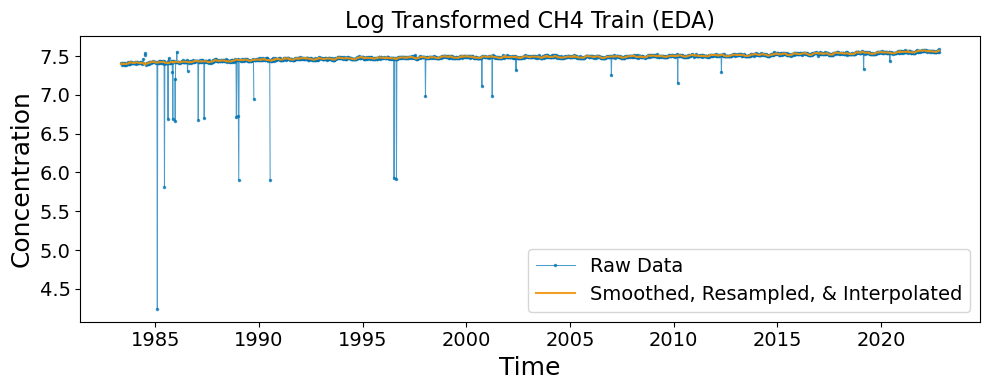

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -1.0657
ADF p-value 0.7286
ADF critical values: {'1%': -3.4335611582014476, '5%': -2.8629585317012416, '10%': -2.567525163136879}

KPSS statistic 6.5167
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:379: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


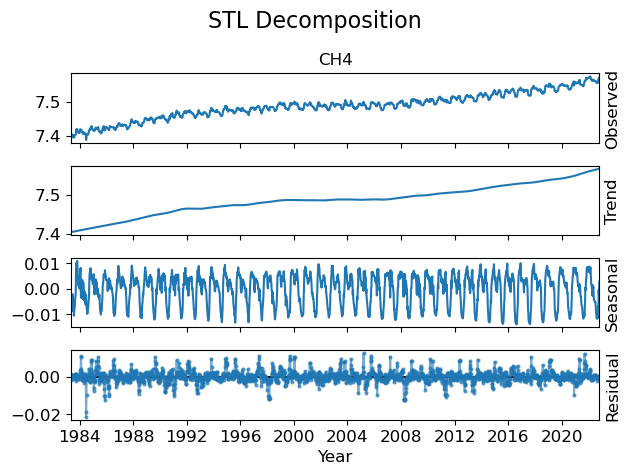

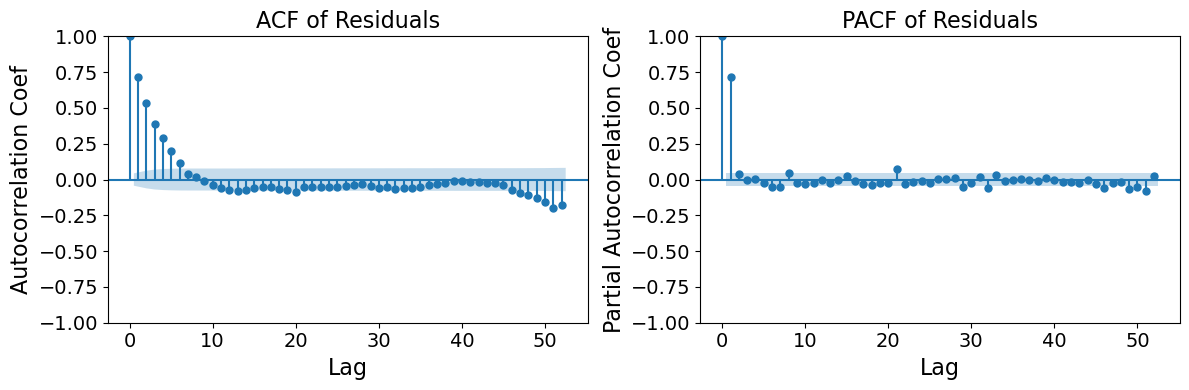


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0027
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0101
Heteroscedasticity detected (White test)


In [16]:
# fit and transform the training data to the GasPreprocessor class, including log transformation to handle heteroscedasticity
# transform the validation and test data using the fitted preprocessor

CH4_train_log_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True, transformation='log')
CH4_train_log_preprocessed = CH4_train_log_preprocessor.fit_transform(
    CH4_train_with_date, 
    custom_title = 'Log Transformed CH4 Train (EDA)'
)

# transform the validation and test data using the fitted preprocessor
CH4_valid_log_preprocessed = CH4_train_log_preprocessor.transform(CH4_valid_with_date)
CH4_test_log_preprocessed = CH4_train_log_preprocessor.transform(CH4_test_with_date)

**Comparison of Statistical Test Results Before and After Log Transformation of the Training Dataseries:**

Non-transformed data:

- ADF statistic: -1.0657, p-value: 0.7286
- KPSS statistic: 6.5167, p-value: 0.0100
- the Processed Data time series is non-stationary according to ADF and KPSS tests.

- Breusch-Pagan p-value: 0.0048
- White test p-value: 0.0018
- Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

Log-transformed data:

- ADF statisti:c -1.0657, p-value: 0.7286
- KPSS statistic: 6.5167, p-value: 0.0100
- the Processed Data time series is non-stationary according to ADF and KPSS tests.

- Breusch-Pagan p-value: 0.0027
- White test p-value: 0.0101
- Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

**Trend/Seasonality:**

Log transformation did not affect stationarity, which is expected and will be addressed through differencing in the SARIMA model.

**Heteroscedasticity**

The log transformation helped slightly based on the White test result, but there is remaining variance in the residuals.  

**Autocorrelation patterns:**

Prior to log transformation, the ACF plot of STL decomposition residuals shows an oscillatory behavior, which is greatly reduced after log transformation.  This is an argument for log transformation since it simplifies the correlation structure and should help tune the SARIMA model orders.  


In [21]:
# verify data structure following transformation and preprocessing 

print('CH4_train shape:', CH4_train_with_date.shape)
print('CH4_valid shape:', CH4_valid_with_date.shape)
print('CH4_test shape:', CH4_test_with_date.shape)

print('\nCH4_train_preprocessed shape:', CH4_train_preprocessed.shape)
print('CH4_valid_preprocessed shape:', CH4_valid_preprocessed.shape)
print('CH4_test_preprocessed shape:', CH4_test_preprocessed.shape)

print('\nCH4_train_log_preprocessed shape:', CH4_train_log_preprocessed.shape)
print('CH4_valid_log_preprocessed shape:', CH4_valid_log_preprocessed.shape)
print('CH4_test_log_preprocessed shape:', CH4_test_log_preprocessed.shape)

CH4_train shape: (2458, 2)
CH4_valid shape: (52, 2)
CH4_test shape: (52, 2)

CH4_train_preprocessed shape: (2059,)
CH4_valid_preprocessed shape: (60,)
CH4_test_preprocessed shape: (66,)

CH4_train_log_preprocessed shape: (2059,)
CH4_valid_log_preprocessed shape: (60,)
CH4_test_log_preprocessed shape: (66,)


The difference in numbers of observations is due to resampling (performed by the GasPreprocessor class).  

# Auto-ARIMA of the preprocessed CH4 train set series

In [22]:
print(f'NaN count before auto_arima: {CH4_train_log_preprocessed.isna().sum()}')

NaN count before auto_arima: 0


In [14]:
# search for the best SARIMA model paramaters for the preprocessed, log transformed CH4 train set with auto-ARIMA
# information criterion = 'aic'

print('Auto_Arima (AIC) results for Preprocessed, Log Transformed CH4 Train Data\n')

stepwise_model_log_aic = auto_arima(
    CH4_train_log_preprocessed,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model_log_aic.summary())

Auto_Arima (AIC) results for Preprocessed, Log Transformed CH4 Train Data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-12278.944, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-12690.389, Time=12.30 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-12925.912, Time=45.90 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-12280.861, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-12922.560, Time=0.38 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=-12924.160, Time=53.67 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=-12926.805, Time=181.97 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=-12924.793, Time=271.41 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=-12274.762, Time=76.14 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=-12949.240, Time=308.24 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=-12944.927, Time=128.13 sec
 ARIMA(1,1,1)(1,0,2)[52] intercept   : AIC=-12939.984, Time=345.70 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : A

In [15]:
# search for the best SARIMA model paramaters for the preprocessed, log transformed CH4 train set with auto-ARIMA
# information criterion = 'bic'

print('Auto_Arima (BIC) results for Preprocessed, Log Transformed CH4 Train Data\n')

stepwise_model_log_bic = auto_arima(
    CH4_train_log_preprocessed,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='bic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model_log_bic.summary())

Auto_Arima (BIC) results for Preprocessed, Log Transformed CH4 Train Data

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : BIC=-12267.685, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : BIC=-12667.871, Time=12.85 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : BIC=-12903.394, Time=45.82 sec
 ARIMA(0,1,0)(0,0,0)[52]             : BIC=-12275.232, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : BIC=-12905.672, Time=0.37 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : BIC=-12903.809, Time=89.07 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : BIC=-12896.012, Time=54.27 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : BIC=-12915.374, Time=0.75 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : BIC=-12917.910, Time=95.90 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : BIC=-12888.303, Time=133.30 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : BIC=-12910.070, Time=123.41 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : BIC=-12916.779, Time=128.05 sec
 ARIMA(1,1,1)(2,0,1)[52] intercept   : BIC=

Interpretation of the results for log transformed/preprocessed train data fit to Auto Arima:

- AIC: Best model:  ARIMA(2,1,1)(0,0,2)[52] intercept
- BIC: Best model:  ARIMA(2,1,1)(1,0,0)[52] intercept

AIC favors best fit despite complexity, while BIC penalized complexity more heavily and favors a simpler model.  Both models have an intercept term and three non-seasonal terms that are statistically significant:  AR(L1), AR(L2), and MA(L1).  The model using AIC has two seasonal terms but only one is statistically significant, MA(L52), while the model using BIC has one significant seasonal term, AR(L52).  Auto-ARIMA finds that one non-seasonal differencing is optimal (d = 1) for both AIC and BIC.  

AIC and BIC values: Lower AIC and BIC scores are better.  Both models have very similar AIC and BIC values.  

Log likelihood score:  Higher log likelihood score is better.  Both models have nearly identical log likelihood scores.

Autocorrelation:  The Ljung-Box test null hypothesis is that the residuals are independently distributed, and therefore don't show autocorrelation.  The BIC model fails to reject the null hypothesis and therefore captures all significant underlying patterns in the data.  However, the AIC model is borderline at p = 0.05.  This model may still be applicable with manual refinement of SARIMA orders.  

| Series | LB value | p-value | Interpretation |
|--------|----------|---------|----------------|
| log transformed, AIC | 3.83 | 0.05 | borderline significant autocorrelation |
| log transformed, BIC| 2.60 | 0.11 | no significant autocorrelation |

Heterscedasticity:  Both models show statistically significant heteroscedasticity in the fit residuals suggesting residual variance.  This may be remedied by further adjustments of the SARIMA orders.  

Distribution of residuals:  Both models also have nearly identical Jarque-Bera test results and indicate that the fit residuals are not normally distributed, which isn't ideal for SARIMA models. 

## Box-Cox Transformed Series

In [ ]:
# search for the best SARIMA model paramaters for the preprocessed, Box-Cox transformed CH4 train set with auto-ARIMA
# information criterion = 'aic'

print('Auto_Arima (AIC) results for Preprocessed, Box-Cox Transformed CH4 Train Data\n')

stepwise_model_aic = auto_arima(
    CH4_train_boxcox_preprocessed,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model_aic.summary())

In [ ]:
# search for the best SARIMA model paramaters for the CH4 train set with auto-ARIMA
# information criterion = 'bic'

print('Auto_Arima (BIC) results for Preprocessed, Box-Cox Transformed CH4 Train Data\n')

stepwise_model_bic = auto_arima(
    CH4_train_boxcox_preprocessed,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='bic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model_bic.summary())

Interpretation of the Box-Cox transformed/preprocessed train data results:

- AIC: Best model:  ARIMA(1,1,0)(2,0,1)[52]
- BIC: Best model:  ARIMA(0,1,0)(0,0,0)[52] 

AIC favors best fit despite complexity, while BIC penalized complexity more heavily and favors a simpler model.  The AIC and BIC values and log likelihood scores for both models are quite similar.  The AIC model is more complex with 5 parameters and an intercept term, while the BIC model is much simpler with a single parameter.  

AIC and BIC values: Lower AIC and BIC scores are better.  Both Box-Cox transformed models have greater AIC and BIC scores compared to the log transformed models.  

Log likelihood score:  Higher log likelihood score is better.  Both Box-Cox transformed models have substantially lower log likelihood scores compared to the log transformed models.  

Autocorrelation:  The Ljung-Box tests for both AIC and BIC models fail to reject the null hypothesis of autocorrelation in the residuals suggesting that they are independently distributed and that each model is a good fit, in this regard.    

Heterscedasticity:  Both models show statistically significant heteroscedasticity in the fit residuals suggesting that either the SARIMA model parameters are not ideal or that the non-constant variance in the residuals need to be modeled (e.g. GARCH).  

Distribution of residuals:  Both models have similar Jarque-Bera test results and indicate that the fit residuals are not normally distributed, which isn't ideal for SARIMA models.  

# SARIMA model

In [ ]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(0,1,0)(1,0,1)[52] intercept*
# *the intercept term was not statistically significant so will ommit it.  

CH4_model = SARIMAX(
    CH4_train_log_preprocessed, 
    order=(0,1,0), 
    seasonal_order=(1,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n') # no intercept

CH4_model_fit = CH4_model.fit(method='lbfgs')
print(CH4_model_fit.summary())

## SARIMA Model Performance on Validation Set

In [ ]:
forecast = CH4_model_fit.get_forecast(steps=len(CH4_valid_log_preprocessed))
forecast_values = forecast.predicted_mean

# inverse transform
forecast_original = CH4_train_log_preprocessor.inverse_transform(forecast_values)
valid_original = CH4_train_log_preprocessor.inverse_transform(CH4_valid_log_preprocessed)

# check for NaNs
print(f'Number of NaNs in forecast_original: {forecast_original.isna().sum()}')
print(f'Number of NaNs in valid_original: {valid_original.isna().sum()}')

# evaluation metrics
metrics = forecast_metrics(valid_original, forecast_original)
print(f'Validation metrics: {metrics}')

In [ ]:
CH4_model2 = SARIMAX(
    CH4_train_log_preprocessed, 
    order=(0,1,0), 
    seasonal_order=(1,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n') # no intercept

CH4_model_fit2 = CH4_model2.fit(method='lbfgs')
print(CH4_model_fit2.summary())

In [ ]:
forecast2 = CH4_model_fit2.get_forecast(steps=len(CH4_valid_log_preprocessed))
forecast_values2 = forecast2.predicted_mean

# inverse transform
forecast_original2 = CH4_train_log_preprocessor.inverse_transform(forecast_values2)
valid_original = CH4_train_log_preprocessor.inverse_transform(CH4_valid_log_preprocessed)

# check for NaNs
print(f'Number of NaNs in forecast_original: {forecast_original2.isna().sum()}')
print(f'Number of NaNs in valid_original: {valid_original.isna().sum()}')

# evaluation metrics
metrics = forecast_metrics(valid_original, forecast_original2)
print(f'Validation metrics: {metrics}')

In [34]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,1)(2,0,1)[52]  

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,1), 
    seasonal_order=(2,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results2 = CH4_model.fit(method='lbfgs')
print(CH4_model_results2.summary())

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                CH4   No. Observations:                 2121
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 52)   Log Likelihood                9102.279
Date:                            Wed, 04 Jun 2025   AIC                         -18190.559
Time:                                    20:07:30   BIC                         -18151.303
Sample:                                05-08-1983   HQIC                        -18176.150
                                     - 12-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0662      0.362     -0.183      0.855      -0.775       0.642
ar.L2          0.0519      0.021   

In [35]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,0)(1,0,0)[52]  

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,0), 
    seasonal_order=(1,0,0,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results3 = CH4_model.fit(method='lbfgs')
print(CH4_model_results3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                CH4   No. Observations:                 2121
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 52)   Log Likelihood                8560.099
Date:                            Wed, 04 Jun 2025   AIC                         -17112.197
Time:                                    21:38:43   BIC                         -17089.664
Sample:                                05-08-1983   HQIC                        -17103.937
                                     - 12-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.009      9.217      0.000       0.066       0.101
ar.L2          0.0707      0.010   

In [36]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,0)(0,0,0)[52]

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,0), 
    seasonal_order=(0,0,0,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results4 = CH4_model.fit(method='lbfgs')
print(CH4_model_results4.summary())

                               SARIMAX Results                                
Dep. Variable:                    CH4   No. Observations:                 2121
Model:               SARIMAX(2, 1, 0)   Log Likelihood                8783.617
Date:                Wed, 04 Jun 2025   AIC                         -17561.233
Time:                        21:41:21   BIC                         -17544.258
Sample:                    05-08-1983   HQIC                        -17555.018
                         - 12-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.009      9.217      0.000       0.066       0.101
ar.L2          0.0707      0.010      6.968      0.000       0.051       0.091
sigma2      1.463e-05   4.61e-08    317.513      0.0

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,0)(1,0,2)[52]

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,0), 
    seasonal_order=(1,0,2,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results5 = CH4_model.fit(method='lbfgs')
print(CH4_model_results5.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2121
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood                9109.379
Date:                                 Wed, 04 Jun 2025   AIC                         -18206.759
Time:                                         21:53:14   BIC                         -18173.109
Sample:                                     05-08-1983   HQIC                        -18194.408
                                          - 12-24-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0460      0.016     -2.913      0.004      -0.077      -0

In [38]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(1,1,0)(1,0,1)[52]

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(1,1,0), 
    seasonal_order=(1,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results6 = CH4_model.fit(method='lbfgs')
print(CH4_model_results6.summary())

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                  CH4   No. Observations:                 2121
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 52)   Log Likelihood                8625.641
Date:                              Thu, 05 Jun 2025   AIC                         -17243.281
Time:                                      09:49:05   BIC                         -17220.746
Sample:                                  05-08-1983   HQIC                        -17235.020
                                       - 12-24-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0898      0.009      9.498      0.000       0.071       0.108
ar.S.L52       0.53

## Model Residuals Analysis

In [39]:
# extract residuals from the models for analysis 

residuals_CH4_model1 = CH4_model_results1.resid
residuals_CH4_model2 = CH4_model_results2.resid
residuals_CH4_model3 = CH4_model_results3.resid
residuals_CH4_model4 = CH4_model_results4.resid
residuals_CH4_model5 = CH4_model_results5.resid
residuals_CH4_model6 = CH4_model_results6.resid


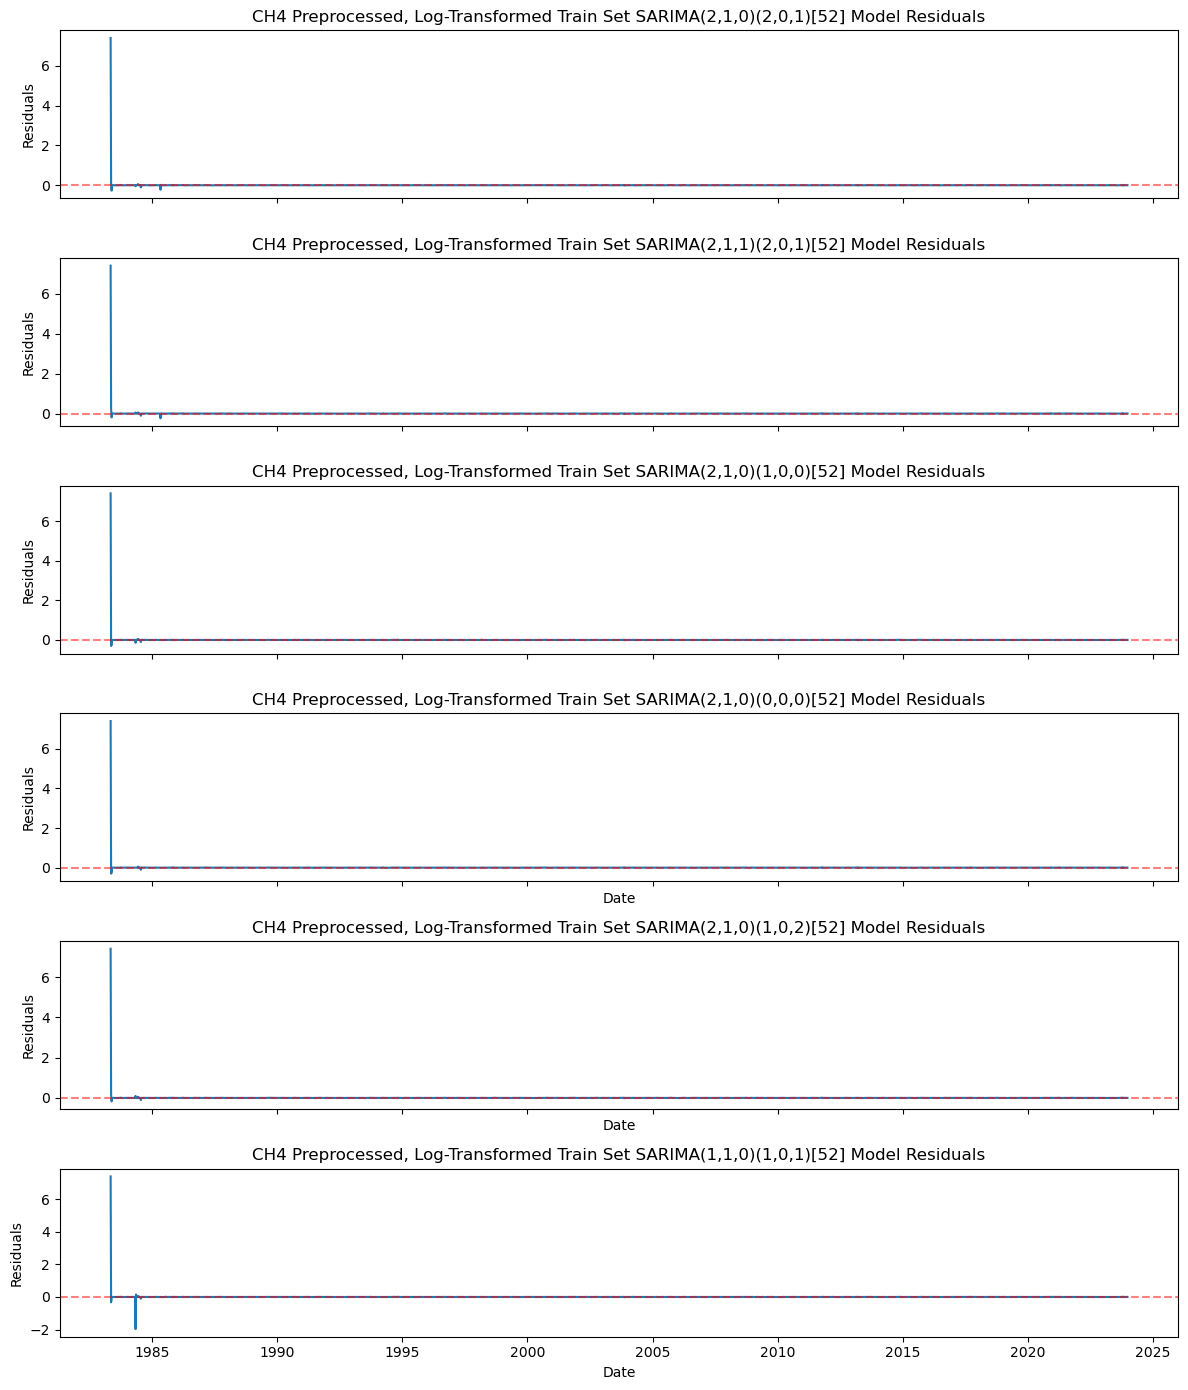

In [40]:
# plot the SARIMA residuals

fig, axs = plt.subplots(6, 1, figsize=(12, 14), sharex=True)

axs[0].plot(residuals_CH4_model1)
axs[0].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(2,0,1)[52] Model Residuals')
axs[0].set_ylabel('Residuals')
axs[0].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[1].plot(residuals_CH4_model2)
axs[1].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,1)(2,0,1)[52] Model Residuals')
axs[1].set_ylabel('Residuals')
axs[1].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[2].plot(residuals_CH4_model3)
axs[2].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(1,0,0)[52] Model Residuals')
axs[2].set_ylabel('Residuals')
axs[2].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[3].plot(residuals_CH4_model4)
axs[3].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(0,0,0)[52] Model Residuals')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Residuals')
axs[3].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[4].plot(residuals_CH4_model5)
axs[4].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(1,0,2)[52] Model Residuals')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Residuals')
axs[4].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[5].plot(residuals_CH4_model6)
axs[5].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(1,1,0)(1,0,1)[52] Model Residuals')
axs[5].set_xlabel('Date')
axs[5].set_ylabel('Residuals')
axs[5].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- Mostly constant variance, centered around 0 from ~ 1985 on. So, the residuals appear to be homoscedastic.
- the large spike at the very beginning is most likely an artifact of the SARIMAX model warm up. This conclusion is based on a test in which the first two years (1983-1984) were trimmed after fitting it to the GasPreprocessor class.  The series was fit to a SARIMAX model exactly as above.  The plot of the residuals showed a large spike, very similar in magnitude at the beginning of the series, which was 1985-01-01.  As seen in the residual plot above, of the full series, there is no spike at 1985-01-01.  
- since I have a substantial amount of data in the train set, I will trim the first 2 years of data residuals for further analysis.   

In [41]:
# trim the first 104 (2 years) residuals to remove early spike

CH4_sarimax_trimmedresids1 = residuals_CH4_model1[105:]
CH4_sarimax_trimmedresids2 = residuals_CH4_model2[105:]
CH4_sarimax_trimmedresids3 = residuals_CH4_model3[105:]
CH4_sarimax_trimmedresids4 = residuals_CH4_model4[105:]
CH4_sarimax_trimmedresids5 = residuals_CH4_model5[105:]
CH4_sarimax_trimmedresids6 = residuals_CH4_model6[105:]


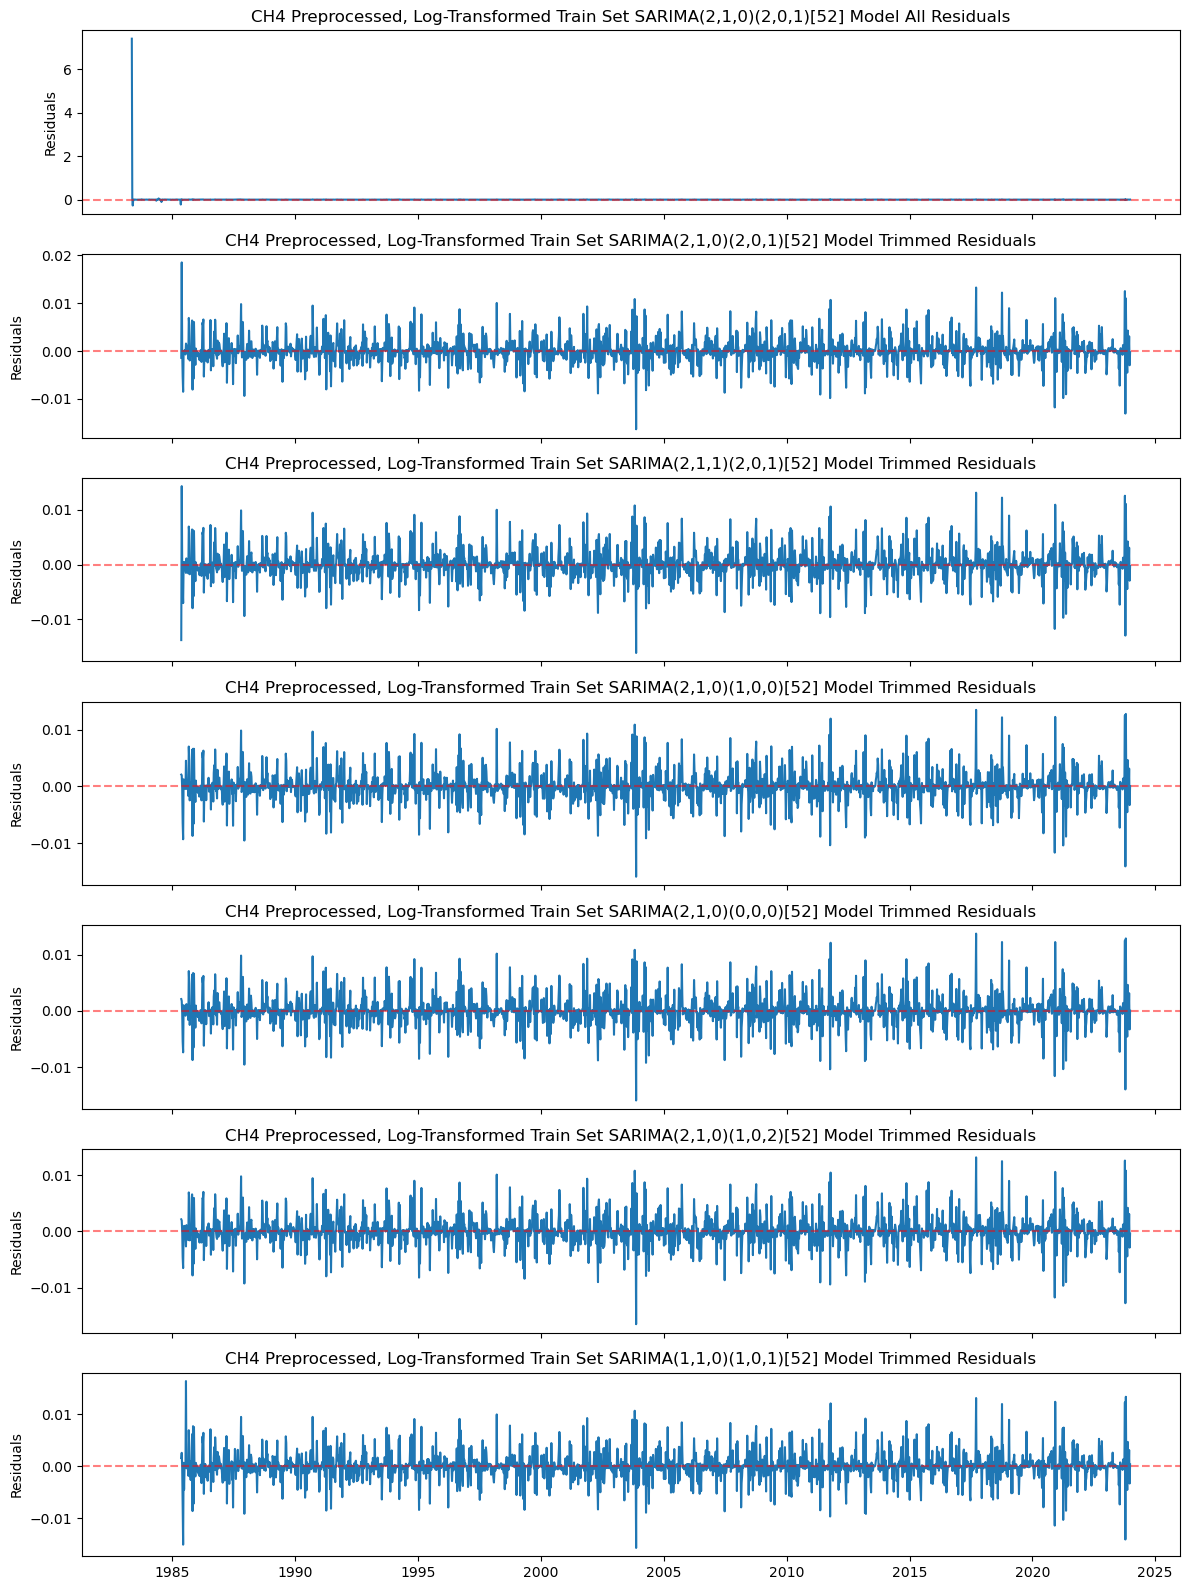

In [42]:
# plot the trimmed SARIMA residuals

fig, axs = plt.subplots(7, 1, figsize=(12, 16), sharex=True)

axs[0].plot(residuals_CH4_model1)
axs[0].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(2,0,1)[52] Model All Residuals')
axs[0].set_ylabel('Residuals')
axs[0].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[1].plot(CH4_sarimax_trimmedresids1)
axs[1].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(2,0,1)[52] Model Trimmed Residuals')
axs[1].set_ylabel('Residuals')
axs[1].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[2].plot(CH4_sarimax_trimmedresids2)
axs[2].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,1)(2,0,1)[52] Model Trimmed Residuals')
axs[2].set_ylabel('Residuals')
axs[2].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[3].plot(CH4_sarimax_trimmedresids3)
axs[3].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(1,0,0)[52] Model Trimmed Residuals')
axs[3].set_ylabel('Residuals')
axs[3].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[4].plot(CH4_sarimax_trimmedresids4)
axs[4].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(0,0,0)[52] Model Trimmed Residuals')
axs[4].set_ylabel('Residuals')
axs[4].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[5].plot(CH4_sarimax_trimmedresids5)
axs[5].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(1,0,2)[52] Model Trimmed Residuals')
axs[5].set_ylabel('Residuals')
axs[5].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[6].plot(CH4_sarimax_trimmedresids6)
axs[6].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(1,1,0)(1,0,1)[52] Model Trimmed Residuals')
axs[6].set_ylabel('Residuals')
axs[6].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

The initial spike seen in the first panel (all residuals) is likely due to start up instability, which is why I also plotted the trimmed residuals.  Overall, the inital spikes are not too concerning since the rest of the residuals are behaving normally.

According to ChatGPT and Deepseek, the residuals of models 1 & 2 (trimmed residuals) are most like white noise, with no obvious trend, drift or changing variance.  Models 3 and 4 have more "clear" signs of variance instability.  

I will examine distribution, autocorrelation via the Ljung-Box test, heteroscedasticity test results, and AIC/BIC scores to decide on a model to move forward with.  

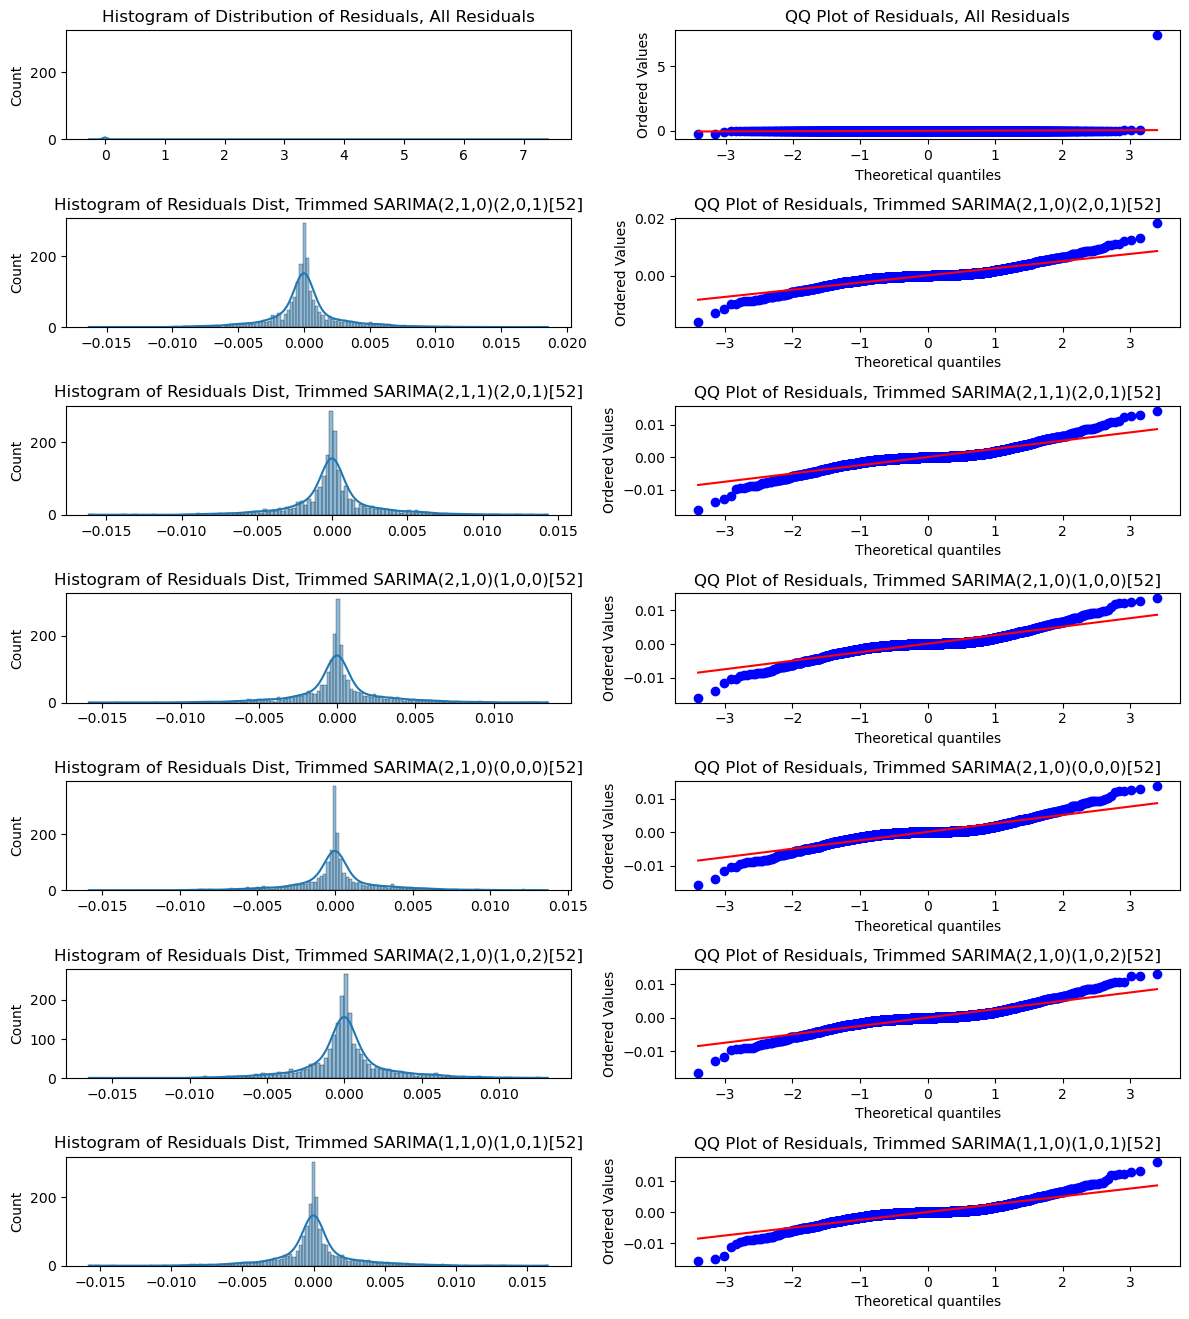

In [52]:
# check residuals for normality

# Histograms
plt.figure(figsize=(12,26))

plt.subplot(14,2,1)
sns.histplot(residuals_CH4_model1, kde=True)
plt.title('Histogram of Distribution of Residuals, All Residuals')

plt.subplot(14,2,3)
sns.histplot(CH4_sarimax_trimmedresids1, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,0)(2,0,1)[52]')

plt.subplot(14,2,5)
sns.histplot(CH4_sarimax_trimmedresids2, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,1)(2,0,1)[52]')

plt.subplot(14,2,7)
sns.histplot(CH4_sarimax_trimmedresids3, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,0)(1,0,0)[52]')

plt.subplot(14,2,9)
sns.histplot(CH4_sarimax_trimmedresids4, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,0)(0,0,0)[52]')

plt.subplot(14,2,11)
sns.histplot(CH4_sarimax_trimmedresids5, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,0)(1,0,2)[52]')

plt.subplot(14,2,13)
sns.histplot(CH4_sarimax_trimmedresids6, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(1,1,0)(1,0,1)[52]')

# QQ Plots
plt.subplot(14,2,2)
stats.probplot(residuals_CH4_model1, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, All Residuals')

plt.subplot(14,2,4)
stats.probplot(CH4_sarimax_trimmedresids1, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,0)(2,0,1)[52]')

plt.subplot(14,2,6)
stats.probplot(CH4_sarimax_trimmedresids2, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,1)(2,0,1)[52]')

plt.subplot(14,2,8)
stats.probplot(CH4_sarimax_trimmedresids3, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,0)(1,0,0)[52]')

plt.subplot(14,2,10)
stats.probplot(CH4_sarimax_trimmedresids4, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,0)(0,0,0)[52]')

plt.subplot(14,2,12)
stats.probplot(CH4_sarimax_trimmedresids5, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,0)(1,0,2)[52]')

plt.subplot(14,2,14)
stats.probplot(CH4_sarimax_trimmedresids6, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(1,1,0)(1,0,1)[52]')

plt.tight_layout()
plt.show()

The trimmed residuals have a much more normal distribution according to the histograms.  The QQ plots show that the mean and median are approximately normal (middle points, close to x axis = 0 fall on the red line). All models show a good, symmetric distribution of residuals.  Models 1 and 2 ((2,1,0)(2,0,1)[52], (2,1,1)(2,0,1)[52]) have a slight edge based on the QQ plots since the ordered values follow the red line more extensively compared to models 3 and 4 that show more deviation at the tails.  

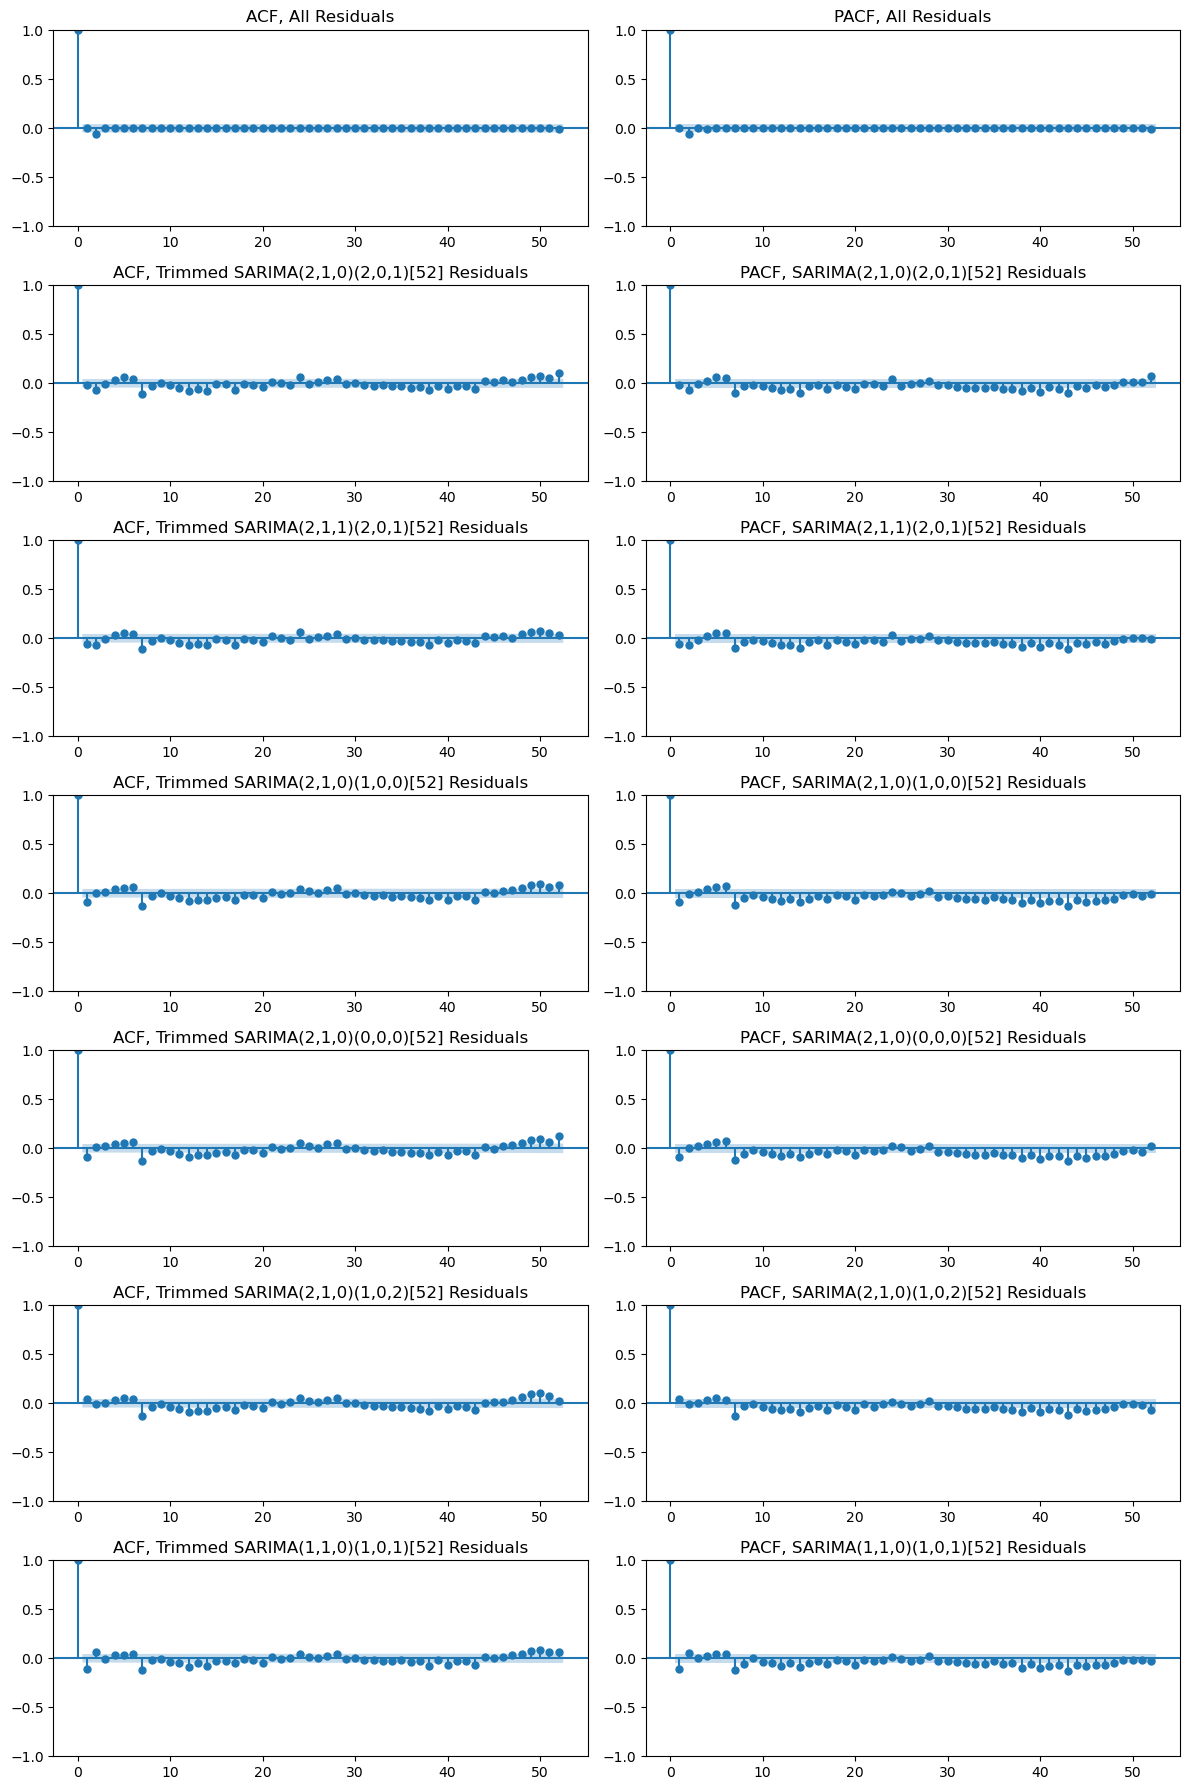

In [61]:
# Check autocorrelation of SARIMA model residuals

fig, axs = plt.subplots(7,2,figsize=(12,18))

plot_acf(residuals_CH4_model1, lags=52, ax=axs[0,0])
axs[0,0].set_title('ACF, All Residuals')

plot_pacf(residuals_CH4_model1, lags=52, ax=axs[0,1])
axs[0,1].set_title('PACF, All Residuals')

plot_acf(CH4_sarimax_trimmedresids1, lags=52, ax=axs[1,0])
axs[1,0].set_title('ACF, Trimmed SARIMA(2,1,0)(2,0,1)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids1, lags=52, ax=axs[1,1])
axs[1,1].set_title('PACF, SARIMA(2,1,0)(2,0,1)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids2, lags=52, ax=axs[2,0])
axs[2,0].set_title('ACF, Trimmed SARIMA(2,1,1)(2,0,1)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids2, lags=52, ax=axs[2,1])
axs[2,1].set_title('PACF, SARIMA(2,1,1)(2,0,1)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids3, lags=52, ax=axs[3,0])
axs[3,0].set_title('ACF, Trimmed SARIMA(2,1,0)(1,0,0)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids3, lags=52, ax=axs[3,1])
axs[3,1].set_title('PACF, SARIMA(2,1,0)(1,0,0)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids4, lags=52, ax=axs[4,0])
axs[4,0].set_title('ACF, Trimmed SARIMA(2,1,0)(0,0,0)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids4, lags=52, ax=axs[4,1])
axs[4,1].set_title('PACF, SARIMA(2,1,0)(0,0,0)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids5, lags=52, ax=axs[5,0])
axs[5,0].set_title('ACF, Trimmed SARIMA(2,1,0)(1,0,2)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids5, lags=52, ax=axs[5,1])
axs[5,1].set_title('PACF, SARIMA(2,1,0)(1,0,2)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids6, lags=52, ax=axs[6,0])
axs[6,0].set_title('ACF, Trimmed SARIMA(1,1,0)(1,0,1)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids6, lags=52, ax=axs[6,1])
axs[6,1].set_title('PACF, SARIMA(1,1,0)(1,0,1)[52] Residuals')

plt.tight_layout()
plt.show()

Model 2 (ARIMA(2,1,1)(2,0,1)[52]) has the tightest lags, especially around lag 52.  

In [49]:
# Run Ljung-Box test on the residuals of the SARIMA models to help interpret the
# ACF and PACF plots 

models = {
    'SARIMA(2,1,0)(2,0,1)[52]': residuals_CH4_model1,
    'SARIMA(2,1,1)(2,0,1)[52]': residuals_CH4_model2,
    'SARIMA(2,1,0)(1,0,0)[52]': residuals_CH4_model3,
    'SARIMA(2,1,0)(0,0,0)[52]': residuals_CH4_model4,
    'SARIMA(2,1,0)(1,0,2)[52]': residuals_CH4_model5,
    'SARIMA(1,1,0)(1,0,1)[52]': residuals_CH4_model6,
}

for name, resid in models.items():
    print(f'\nLjung-Box test for {name}') 
    result = acorr_ljungbox(resid, lags=[7,13,26,52], return_df=True)
    print(result[['lb_stat', 'lb_pvalue']])


Ljung-Box test for SARIMA(2,1,0)(2,0,1)[52]
     lb_stat  lb_pvalue
7   2.975452   0.887264
13  2.977423   0.998014
26  2.986011   1.000000
52  3.083250   1.000000

Ljung-Box test for SARIMA(2,1,1)(2,0,1)[52]
     lb_stat  lb_pvalue
7   3.687365   0.815000
13  3.688901   0.994073
26  3.697578   1.000000
52  3.816566   1.000000

Ljung-Box test for SARIMA(2,1,0)(1,0,0)[52]
     lb_stat  lb_pvalue
7   5.970740   0.543170
13  5.973152   0.947125
26  5.981339   0.999984
52  6.791468   1.000000

Ljung-Box test for SARIMA(2,1,0)(0,0,0)[52]
     lb_stat  lb_pvalue
7   5.970401   0.543210
13  5.972125   0.947162
26  5.980257   0.999984
52  5.986740   1.000000

Ljung-Box test for SARIMA(2,1,0)(1,0,2)[52]
     lb_stat  lb_pvalue
7   2.270632   0.943357
13  2.272042   0.999538
26  2.280225   1.000000
52  2.682354   1.000000

Ljung-Box test for SARIMA(1,1,0)(1,0,1)[52]
       lb_stat     lb_pvalue
7     4.641154  7.036601e-01
13    4.678359  9.816083e-01
26    4.688427  9.999988e-01
52  139.914613

All models except for model 6(SARIMA(1,1,0)(1,0,1)[52]) fail to reject the H0 hypothesis of no autocorrelation at all lags.  Lag 52 of model 6 is statistically significant, suggesting that this model performs the worst for capturing all seasonal structure.  

In [53]:
# check for heteroscesdasticity in the log-transformed data with trimmed residuals

print('Heteroscedasticity Tests for CH4 Train Set Model Residuals\n')

print('Model 1: SARIMA(2,1,0)(2,0,1)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model1, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids1, label='Trimmed Residuals')

print('\nModel 2: SARIMA(2,1,1)(2,0,1)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model2, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids2, label='Trimmed Residuals')

print('\nModel 3: SARIMA(2,1,0)(1,0,0)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model3, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids3, label='Trimmed Residuals')

print('\nModel 4: SARIMA(2,1,0)(0,0,0)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model4, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids4, label='Trimmed Residuals')

print('\nModel 5: SARIMA(2,1,0)(1,0,2)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model5, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids5, label='Trimmed Residuals')

print('\nModel 6: SARIMA(1,1,0)(1,0,1)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model6, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids6, label='Trimmed Residuals')

Heteroscedasticity Tests for CH4 Train Set Model Residuals

Model 1: SARIMA(2,1,0)(2,0,1)[52]

All Residuals
Breusch-Pagan p-value: 0.0826
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0181
Heteroscedasticity detected (White test)

Trimmed Residuals
Breusch-Pagan p-value: 0.5449
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.2954
No heteroscedasticity detected (White test)

Model 2: SARIMA(2,1,1)(2,0,1)[52]

All Residuals
Breusch-Pagan p-value: 0.0824
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0180
Heteroscedasticity detected (White test)

Trimmed Residuals
Breusch-Pagan p-value: 0.5859
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.2368
No heteroscedasticity detected (White test)

Model 3: SARIMA(2,1,0)(1,0,0)[52]

All Residuals
Breusch-Pagan p-value: 0.0822
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0179
Heteroscedasticity detected (Whit

{'bp_pvalue': 0.6903008367786996, 'white_pvalue': 0.09062230194049677}

The Breusch-Pagan test results indicate that heteroscedasticity was not detected in the residuals of all models, trimmed and untrimmed. Importantly both Breusch-Pagan and White tests are negative for heteroscedasticity for the trimmed residuals of models 3, 4, and 5.  

### Model Performance Metrics  
(from respective model summaries)

**Optimization Method**: L-BFGS  

```text
Model 1: ARIMA(2,1,0)(2,0,1)[52]  
    AIC: -18144.344 | BIC: -18110.694  

Model 2: ARIMA(2,1,1)(2,0,1)[52]  
    AIC: -18180.986 | BIC: -18141.728  

Model 3: ARIMA(2,1,0)(1,0,0)[52]  
    AIC: -17122.350 | BIC: -17099.815  

Model 4: ARIMA(2,1,0)(0,0,0)[52]  
    AIC: -17571.405 | BIC: -17554.429  

MODEL 5: SARIMA(2,1,0)(1,0,2)[52]  **BEST**
    AIC: -18211.695 | BIC: -18178.040  

Model 6: SARIMA(1,1,0)(1,0,1)[52]  
    AIC: -17253.441 | BIC: -17230.904  
```

### Legend  
- **AIC**: Lower = Better (penalizes complexity)  
- **BIC**: Lower = Better (stronger penalty than AIC)  

**Best Model**: model 5 SARIMA(2,1,0)(1,0,2)[52]
- Model 5 has significantly lower AIC and BIC scores.  Its AIC score is 31 points lower than the model with the next lowest AIC score, and a BIC score that is 37 points lower.  A difference > 10 is considered substantial.
- Models 3, 4, and 6 have the highest AIC and BIC scores.
- Model 5, along with models 1-4 reject the Ljung_Box test H0 hypothesis for autocorrelation at all tested lags.  Model 6 failed to reject the H0 hypothesis at lag 52. So model 6 is ruled out in this grouping.
-  All models show no heteroscedasticity in trimmed residuals.
-  The QQ plot of model 5 appears to hug the red line at the tails more than other models.
-  Model 5 is simpler, uses fewer parameters, than models 1 and 2.

# Save Best Model Parameters for Production

In [71]:
import json
from datetime import datetime

model_config = {
    'model_type': 'SARIMAX',
    'order': (2,1,0),
    'seasonal_order': (1,0,2,52),
    'trend': 'n',
    'enforce_stationarity': False,
    'envorce_invertibility': False,
    'training_data_range': {
        'start': CH4_train_logged.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_logged.index[-1].strftime('%Y-%m-%d')
    },
    'fit_method': 'lbfgs',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

# save as JSON file
with open('../results/CH4_train_best_model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print('CH4 train set model configuration saved.  Re-fit in next notebook.')

CH4 train set model configuration saved.  Re-fit in next notebook.


# Save Logged Data for use in Forecasting

In [69]:
# define path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

# save the logged CH4 train data
CH4_train_logged.to_csv(
    output_dir / 'ch4_train_logged.csv', 
    index=True, # keep the datetime index
    header=['log_ch4_ppb'],
    float_format='%.5f'
)

print(f'Saved to: {output_dir / "ch4_train_logged.csv"}')

Saved to: ..\data\processed\ch4_train_logged.csv


In [70]:
# save the logged CH4 test data
CH4_test_logged.to_csv(
    output_dir / 'ch4_test_logged.csv', 
    index=True, # keep the datetime index
    header=['log_ch4_ppb'],
    float_format='%.5f'
)

print(f'Saved to: {output_dir / "ch4_test_logged.csv"}')

Saved to: ..\data\processed\ch4_test_logged.csv
